# Inspecting and modifying different channel types

`neurax` provides an implementation of different ion channel types. In this tutorial, we will show the behaviour of some of the ion channels.
Currently these channels are based on [Pospischil et al. (2008)].

In [2]:
%load_ext autoreload
%autoreload 2

# I have experienced stability issues with float32.
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad

import neurax as nx
from neurax.channels import (Leak,
                             NaChannelPospi, 
                             KChannelPospi,
                             KmChannelPospi,
                             CaLChannelPospi,
                             CaTChannelPospi)

### Basic Na-K spiking mechanism
aka 'Fast spiking neurons'


In [209]:
# First we define a simple point neuron

# Number of segments per branch.
nseg_per_branch = 1
comp = nx.Compartment()
branch = nx.Branch([comp])

# point neuron:
cell = nx.Cell([branch], parents=jnp.asarray([-1]))


In [210]:
# insert channels
cell.insert(Leak())
cell.insert(NaChannelPospi())
cell.insert(KChannelPospi())

In [220]:
# Pospischil parameters for Fig. 3

cell.set_params("length", 67) 
cell.set_params("radius", 67) 

# leak current
cell.set_params("gl", 1.5e-4) 
cell.set_params("el", -70) 

# Na channel
cell.set_params("gNa", 0.05) 

# K channel
cell.set_params("gK", 0.01) 


# optional parameters: 
# spike threshold
v_threshold = -60.
cell.set_params("vt", v_threshold) # threshold for Na
cell.set_params("vt_", v_threshold) # threshold for K



In [221]:
# Stimulus.
i_delay = 200.0  # ms
i_amp = 1 # nA 
i_dur = 400.0  # ms
i_offset = 0.0

# Duration and step size.
dt = 0.025  # ms
t_max = 800.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

stims = [nx.Stimulus(0, 0, 0.0, nx.step_current(i_delay, i_dur, i_amp, time_vec, i_offset=i_offset))]
recs = [nx.Recording(0, 0, 0.0)]

# run the model
s = nx.integrate(cell, stims, recs, delta_t=dt)

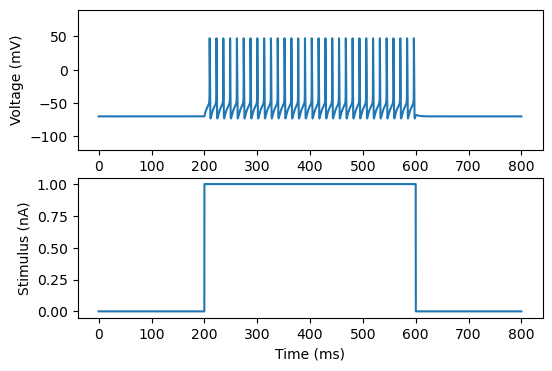

In [222]:
plt.figure(1,  figsize=(6, 4))
ax = plt.subplot(211)
_ = ax.plot(time_vec, s.T[:-1])
_ = ax.set_ylim([-120, 90])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")


ax = plt.subplot(212)
ax.plot(time_vec,stims[0].current)
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Stimulus (nA)")



### Time adaptive neurons
aka 'regular spiking neurons'

For this we need to add a slow patassium channel:

In [30]:
# First we define a simple point neuron

# Number of segments per branch.
nseg_per_branch = 1
comp = nx.Compartment()
branch = nx.Branch([comp])

# point neuron:
cell = nx.Cell([branch], parents=jnp.asarray([-1]))

# insert channels
cell.insert(Leak())
cell.insert(NaChannelPospi())
cell.insert(KChannelPospi())
cell.insert(KmChannelPospi())

In [61]:
# Pospischil parameters for Fig. 1

cell.set_params("length", 96) 
cell.set_params("radius", 96) 

# Leak
cell.set_params("gl", 1e-4) 
cell.set_params("el", -70) 

# Na channel
cell.set_params("gNa", 0.05) 

# K channel
cell.set_params("gK", 0.005) 

# Km channal
cell.set_params("gM", 7e-5) 
cell.set_params("taumax", 4000.) # time adaptation constant

In [68]:
# Stimulus.
i_delay = 200.0  # ms
i_amp = 1.1 # nA 
i_dur = 600.0  # ms
i_offset = 0.0

# Duration and step size.
dt = 0.025  # ms
t_max = 1000.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

stims = [nx.Stimulus(0, 0, 0.0, nx.step_current(i_delay, i_dur, i_amp, time_vec, i_offset=i_offset))]
recs = [nx.Recording(0, 0, 0.0)]

# run the model
s = nx.integrate(cell, stims, recs, delta_t=dt)

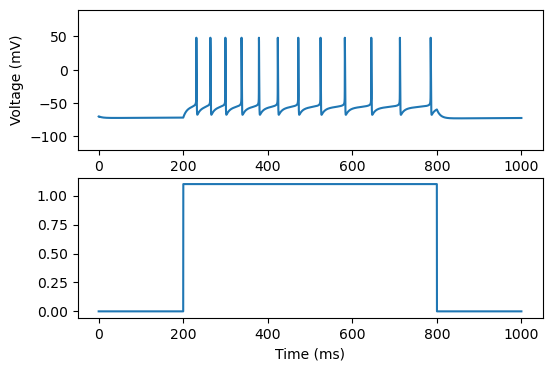

In [69]:
plt.figure(1,  figsize=(6, 4))
ax = plt.subplot(211)
_ = ax.plot(time_vec, s.T[:-1])
_ = ax.set_ylim([-120, 90])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")


ax = plt.subplot(212)
ax.plot(time_vec,stims[0].current)
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Stimulus (nA)")



### Intrinsically bursting neurons
Let's add a high threshold (L-type) Calcium channel

In [70]:
# First we define a simple point neuron

# Number of segments per branch.
nseg_per_branch = 1
comp = nx.Compartment()
branch = nx.Branch([comp])

# point neuron:
cell = nx.Cell([branch], parents=jnp.asarray([-1]))


# insert channels
cell.insert(Leak())
cell.insert(NaChannelPospi())
cell.insert(KChannelPospi())
cell.insert(KmChannelPospi())
cell.insert(CaLChannelPospi())

In [108]:
# Pospischil parameters for Fig. 5

cell.set_params("length", 96) 
cell.set_params("radius", 96) 

# Leak
cell.set_params("gl", 1e-5)
cell.set_params("el", -70.)

# Na channel 
cell.set_params("gNa", 0.05) 

# K channel
cell.set_params("gK", 0.005) 

# Km channel
cell.set_params("gM", 1e-4)  # 1e-5 # this needs to be changed
cell.set_params("taumax", 4000.)

# CaL channel
cell.set_params("gCaL", 2e-4) #2e-4

# initial V state
cell.set_states('voltages',-80)

In [109]:
# Stimulus.
i_delay = 200.0  # ms
i_amp = 0.5 # nA 
i_dur = 1000.0  # ms
i_offset = 0.0

# Duration and step size.
dt = 0.0025  # ms
t_max = 1400.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

stims = [nx.Stimulus(0, 0, 0.0, nx.step_current(i_delay, i_dur, i_amp, time_vec, i_offset=i_offset))]
recs = [nx.Recording(0, 0, 0.0)]

# run the model
s = nx.integrate(cell, stims, recs, delta_t=dt)


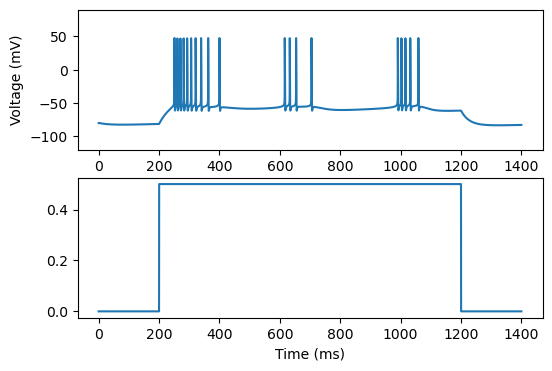

In [110]:
plt.figure(1,  figsize=(6, 4))
ax = plt.subplot(211)
_ = ax.plot(time_vec, s.T[:-1])
_ = ax.set_ylim([-120, 90])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")


ax = plt.subplot(212)
ax.plot(time_vec,stims[0].current)
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Stimulus (nA)")



In [117]:
# Pospischil parameters for Fig. 6

# Leak
cell.set_params("gl", 1e-4)
cell.set_params("el", -75.)

# Na channel
cell.set_params("gNa", 0.05) 
cell.set_params("vt", -58.) 

# K channel
cell.set_params("gK", 0.0042)
cell.set_params("vt_", -58.)  

# Km channel
cell.set_params("gM", 4.2e-5) #4.2e-5
cell.set_params("taumax", 1000.) #1000
  
# CaL channel
cell.set_params("gCaL", 0.00012)


cell.set_states('voltages',-75)

In [128]:
# Stimulus.
i_delay = 200.0  # ms
i_amp = 1.3 # nA 
i_dur = 1000.0  # ms
i_offset = 0.0

# Duration and step size.
dt = 0.0025  # ms
t_max = 1400.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

stims = [nx.Stimulus(0, 0, 0.0, nx.step_current(i_delay, i_dur, i_amp, time_vec, i_offset=i_offset))]
recs = [nx.Recording(0, 0, 0.0)]

# run the model
s = nx.integrate(cell, stims, recs, delta_t=dt)


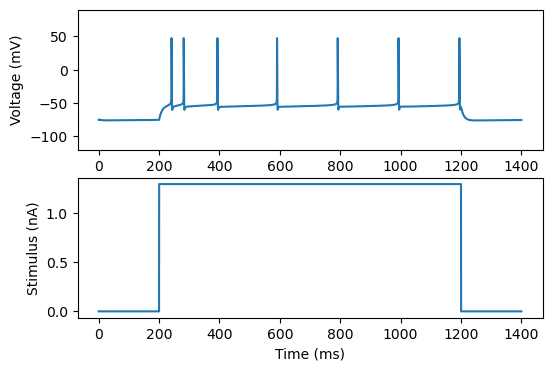

In [130]:
plt.figure(1,  figsize=(6, 4))
ax = plt.subplot(211)
_ = ax.plot(time_vec, s.T[:-1])
_ = ax.set_ylim([-120, 90])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")


ax = plt.subplot(212)
ax.plot(time_vec,stims[0].current)
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Stimulus (nA)")



### And finally neurons with rebound spikes
(adding a T-type Calcium channel)

In [223]:
# First we define a simple point neuron

# Number of segments per branch.
nseg_per_branch = 1
comp = nx.Compartment()
branch = nx.Branch([comp])

# point neuron:
cell = nx.Cell([branch], parents=jnp.asarray([-1]))


# insert channels
cell.insert(Leak())
cell.insert(NaChannelPospi())
cell.insert(KChannelPospi())
cell.insert(KmChannelPospi())
cell.insert(CaTChannelPospi())

In [224]:
# Pospischil parameters for Fig. 8
# with small changes, reproducing qualitative behaviour

cell.set_params("length", 96) 
cell.set_params("radius", 96) 

# Leak 
cell.set_params("gl", 1e-5)
cell.set_params("el", -70.)

# Na channel
cell.set_params("gNa", 0.05) 

# K channel
cell.set_params("gK", 0.005)

# Km channel
cell.set_params("gM", 3e-4) #3e-5 # this needs to be changed to 3e-4
cell.set_params("taumax", 4000.)
  
# CaT channel
cell.set_params("gCaT", 8e-4) # 4e-4 # this needs to be changed to 8e-4


cell.set_states('voltages',-80)

In [225]:
# Stimulus.
i_delay = 600.0  # ms
i_amp = -.1 # nA 0.8
i_dur = 500.0  # ms
i_offset = 0.0

# Duration and step size.
dt = 0.0025  # ms
t_max = 2000.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

stims = [nx.Stimulus(0, 0, 0.0, nx.step_current(i_delay, i_dur, i_amp, time_vec, i_offset=i_offset))]
recs = [nx.Recording(0, 0, 0.0)]

s = nx.integrate(cell, stims, recs, delta_t=dt)

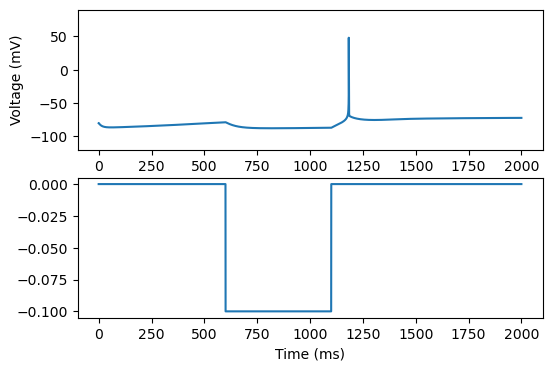

In [226]:
plt.figure(1,  figsize=(6, 4))
ax = plt.subplot(211)
_ = ax.plot(time_vec, s.T[:-1])
_ = ax.set_ylim([-120, 90])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")


ax = plt.subplot(212)
ax.plot(time_vec,stims[0].current)
_ = ax.set_xlabel("Time (ms)")
